In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
import os
import random

# Count the no. of images in each folder

In [10]:
def count_images_in_subfolders(root_folder):
    class_counts = {}
    for foldername in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, foldername)
        if os.path.isdir(folder_path):
            image_count = len([filename for filename in os.listdir(folder_path) if filename.endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[foldername] = image_count
    return class_counts

# Print the image distribution in each folder

In [11]:
def plot_bar_graph(class_counts, name, color):
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=color)
    plt.xlabel('Subfolders')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images in {name}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

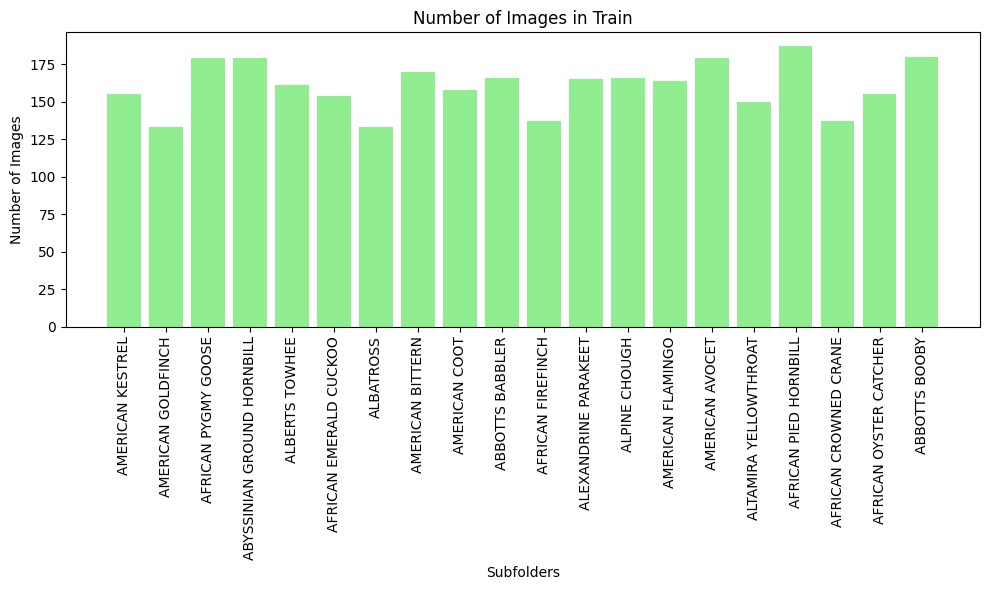

In [12]:
class_counts = count_images_in_subfolders('/kaggle/input/birds-20-species-image-classification/train')
plot_bar_graph(class_counts, 'Train', 'lightgreen')

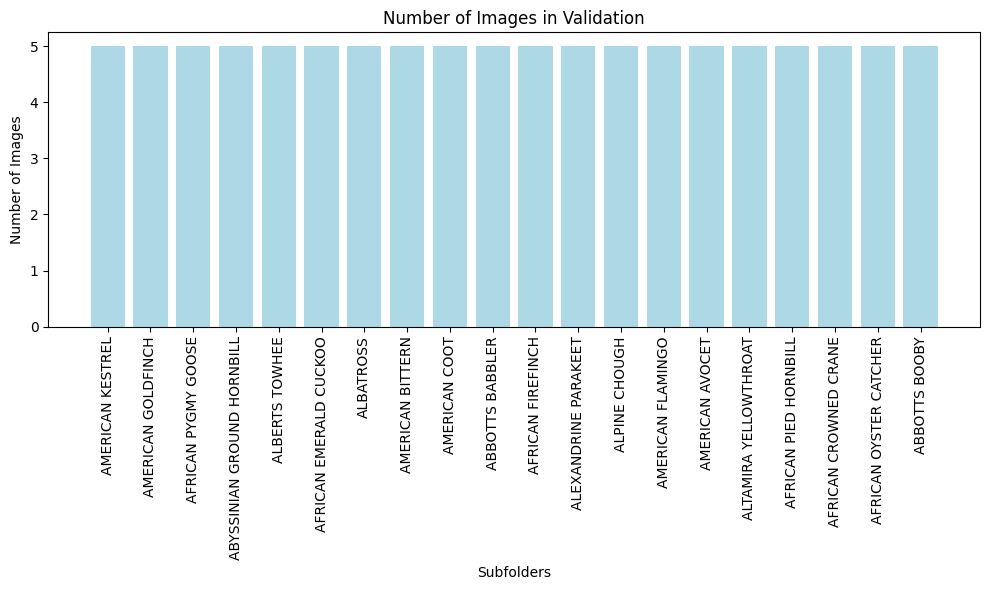

In [13]:
class_counts = count_images_in_subfolders('/kaggle/input/birds-20-species-image-classification/valid')
plot_bar_graph(class_counts, 'Validation', 'lightblue')

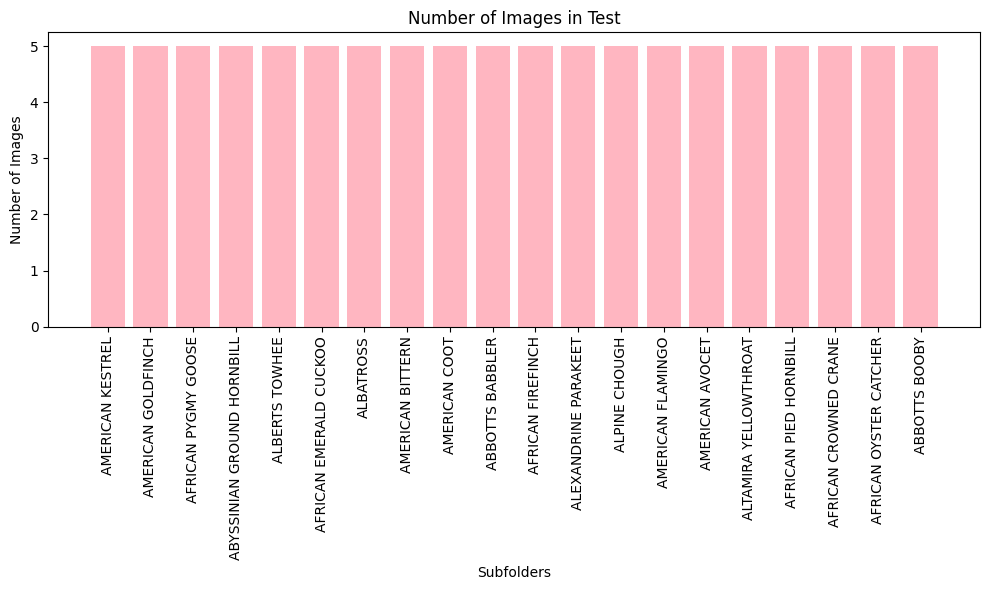

In [14]:
class_counts = count_images_in_subfolders('/kaggle/input/birds-20-species-image-classification/test')
plot_bar_graph(class_counts, 'Test', 'lightpink')

# Visualize a few images from the training set

In [15]:
def visualize_random_images(directory, num_images=5):
    # Get a list of all image files
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))

    # Randomly select images
    random_images = random.sample(image_files, num_images)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, image_path in enumerate(random_images):
        img = mpimg.imread(image_path)
        subfolder_name = os.path.basename(os.path.dirname(image_path))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(subfolder_name)  # Set subfolder name as title
    plt.show()

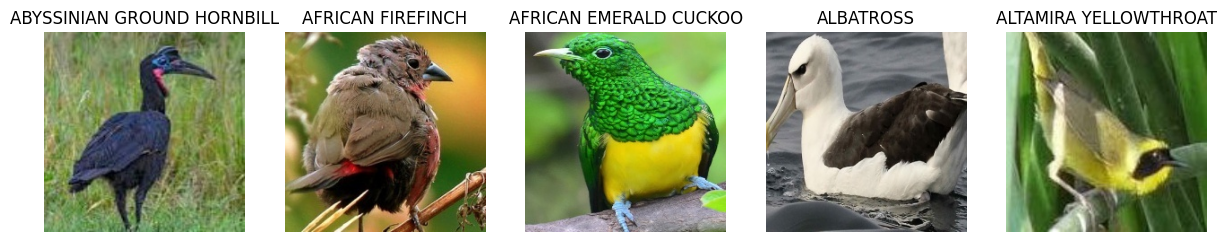

In [16]:
visualize_random_images('/kaggle/input/birds-20-species-image-classification/train', num_images=5)

# Create data loaders from Training and Validation sets.
## *Apply augmentation only for the Training set*

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

tf.random.set_seed(42)

train_dir = '/kaggle/input/birds-20-species-image-classification/train'
valid_dir =  '/kaggle/input/birds-20-species-image-classification/valid'

train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                              target_size = IMG_SHAPE,
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              seed = 42)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                              target_size = IMG_SHAPE,
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              seed = 42)

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


In [18]:
len(train_data_augmented), len(valid_data)

(101, 7)

In [19]:
classes = list(train_data_augmented.class_indices.keys())

In [20]:
classes

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL']

# **AlexNet Model**

In [26]:
model= tf.keras.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(64, (11, 11), strides=(4, 4), padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(192, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    
    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')
])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
             metrics = ['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [27]:
history = model.fit(train_data_augmented,
         epochs = 60,
         validation_data = valid_data)

Epoch 1/60
  1/101 ━━━━━━━━━━━━━━━━━━━━ 13:31 8s/step - accuracy: 0.0312 - loss: 3.0008

W0000 00:00:1710175895.252665     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/101 ━━━━━━━━━━━━━━━━━━━━ 8s 461ms/step - accuracy: 0.0637 - loss: 2.9775

W0000 00:00:1710175933.030838     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.0658 - loss: 2.9689

W0000 00:00:1710175939.057934     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 52s 443ms/step - accuracy: 0.0661 - loss: 2.9679 - val_accuracy: 0.1300 - val_loss: 2.6496
Epoch 2/60


W0000 00:00:1710175939.575086     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 422ms/step - accuracy: 0.1301 - loss: 2.7525 - val_accuracy: 0.1600 - val_loss: 2.6690
Epoch 3/60
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 421ms/step - accuracy: 0.1616 - loss: 2.5638 - val_accuracy: 0.2600 - val_loss: 2.0963
Epoch 4/60
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 427ms/step - accuracy: 0.2823 - loss: 2.2132 - val_accuracy: 0.3400 - val_loss: 1.8291
Epoch 5/60
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 420ms/step - accuracy: 0.3376 - loss: 2.0306 - val_accuracy: 0.3600 - val_loss: 1.7863
Epoch 6/60
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 421ms/step - accuracy: 0.3772 - loss: 1.9039 - val_accuracy: 0.4300 - val_loss: 1.6776
Epoch 7/60
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 418ms/step - accuracy: 0.4137 - loss: 1.8131 - val_accuracy: 0.4900 - val_loss: 1.6321
Epoch 8/60
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 423ms/step - accuracy: 0.4557 - loss: 1.7020 - val_accuracy: 0.5000 - val_loss: 1.4239
Epoch 9/60
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 418ms/step - accuracy: 0.4739 - loss: 1.6459 - val

<Axes: >

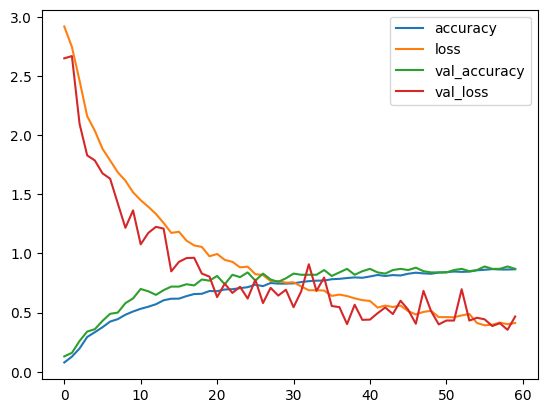

In [28]:
pd.DataFrame(history.history).plot()

# Analyse the performance of our model in Test directory

In [29]:
test_data_dir = '/kaggle/input/birds-20-species-image-classification/test'

test_datagen = ImageDataGenerator(rescale=1./255)  # You can add other preprocessing options here if needed

batch_size = 32

test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False 
)

Found 100 images belonging to 20 classes.


In [31]:
train_evaluation = model.evaluate(train_data_augmented)
train_accuracy = train_evaluation[1]
train_loss = train_evaluation[0]


valid_evaluation = model.evaluate(valid_data)
valid_accuracy = valid_evaluation[1]
valid_loss = valid_evaluation[0]


test_evaluation = model.evaluate(test_data)
test_accuracy = test_evaluation[1]
test_loss = test_evaluation[0]

# Generate a table
from tabulate import tabulate

data = [
    ["Training", train_accuracy, train_loss],
    ["Validation", valid_accuracy, valid_loss],
    ["Test", test_accuracy, test_loss]
]

headers = ["Dataset", "Accuracy", "Loss"]

table = tabulate(data, headers=headers, tablefmt="grid")

print(table)


  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.8438 - loss: 0.5140

W0000 00:00:1710178676.596304     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 445ms/step - accuracy: 0.9047 - loss: 0.3120
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7500 - loss: 0.4293

W0000 00:00:1710178721.134781     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8364 - loss: 0.4475
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8438 - loss: 0.3420

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.9013 - loss: 0.2308
+------------+------------+----------+
| Dataset    |   Accuracy |     Loss |
+============+============+==========+
| Training   |   0.905237 | 0.30621  |
+------------+------------+----------+
| Validation |   0.87     | 0.415783 |
+------------+------------+----------+
| Test       |   0.92     | 0.178322 |
+------------+------------+----------+


In [32]:
test_data.classes

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19],
      dtype=int32)

In [33]:
test_predictions = model.predict(test_data)
test_predictions = np.argmax(test_predictions, axis=1)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 

W0000 00:00:1710178734.822083     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


W0000 00:00:1710178735.423805     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [34]:
test_predictions

array([17, 10, 13,  0, 10,  1,  1,  0,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6, 12,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14,  3, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18,  8, 19, 19, 19, 19])

<Axes: >

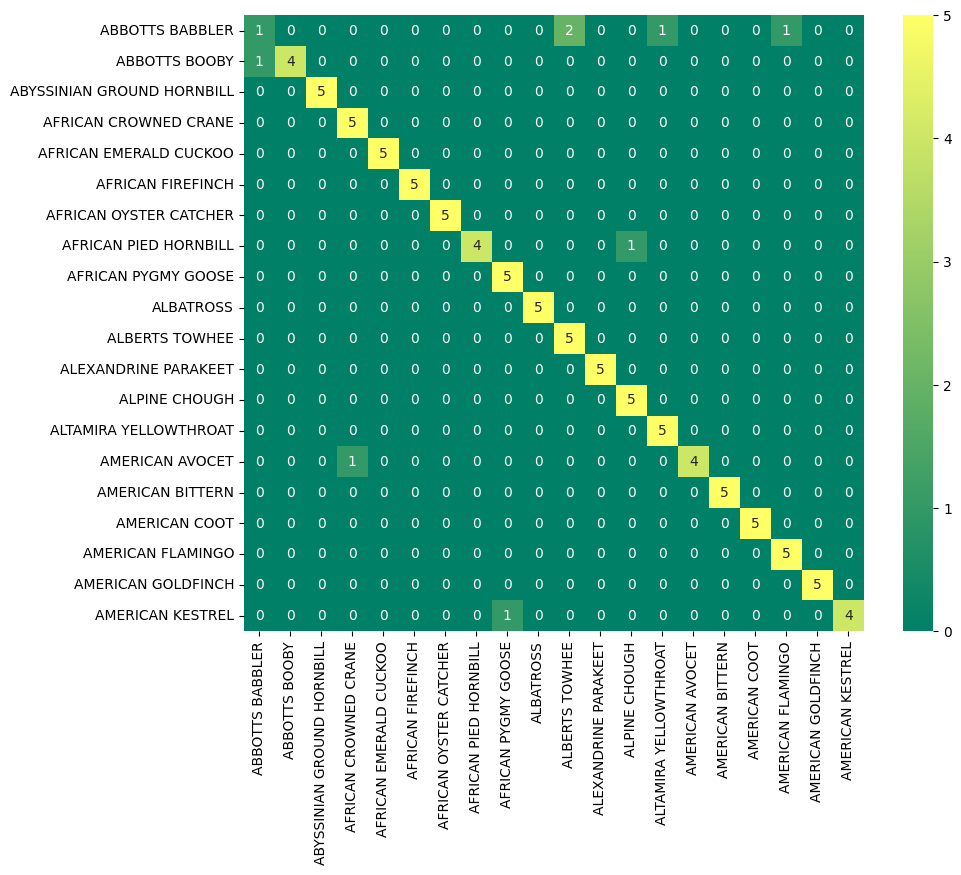

In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = test_data.classes
y_pred = test_predictions
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='summer', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())

# Use the model to predict for the given test images

In [36]:
def predict_images(directory):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory)]
    num_images = len(image_paths)
    
    images = []
    predictions = []
    
    for image_path in image_paths:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, (224, 224))
        image = image / 255.0
        images.append(image)
    
    images = np.array(images)
    
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    plt.figure(figsize = (20,20))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(classes[predicted_classes[i]])
        plt.axis(False)
        
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


W0000 00:00:1710178747.577563     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


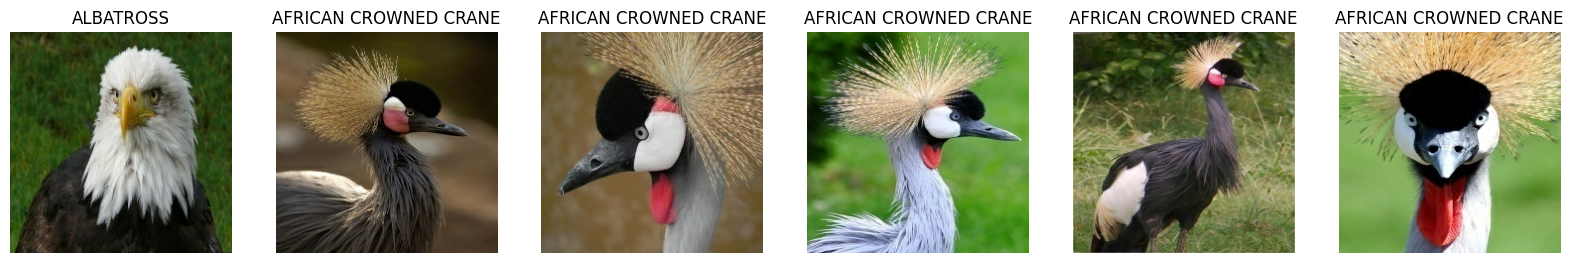

In [37]:
predict_images('/kaggle/input/birds-20-species-image-classification/images to predict')

In [38]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 192)    │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 13, 13, 384)    │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 13, 13, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │        20,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,785,214 (136.51 MB)

 Trainable params: 11,928,404 (45.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,856,810 (91.01 MB)